In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

In [2]:
# Load the dataset
df = pd.read_csv('machine_failure_dataset.csv')

# Display the shape of dataset
print("\n----- Dataset Shape -----")
print(df.shape)

# Display the first few rows
print("\n----- Dataset Head -----")
print(df.head())

# Get information about the dataset
print("\n----- Dataset Info -----")
df.info()

# Get descriptiona about dataset
print("\n----- Dataset Description -----")
df.describe()


----- Dataset Shape -----
(1000, 6)

----- Dataset Head -----
   Temperature  Vibration  Power_Usage   Humidity Machine_Type  Failure_Risk
0    74.967142  56.996777     8.649643  20.460962         Mill             1
1    68.617357  54.623168     9.710963  25.698075        Lathe             0
2    76.476885  50.298152     8.415160  27.931972        Drill             1
3    85.230299  46.765316     9.384077  39.438438        Lathe             1
4    67.658466  53.491117     6.212771  32.782766        Drill             1

----- Dataset Info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperature   1000 non-null   float64
 1   Vibration     1000 non-null   float64
 2   Power_Usage   1000 non-null   float64
 3   Humidity      1000 non-null   float64
 4   Machine_Type  1000 non-null   object 
 5   Failure_Risk  1000 non-null   int64  


,Temperature,Vibration,Power_Usage,Humidity,Failure_Risk
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,70.193321,50.354181,10.011668,29.906404,0.300000
std,9.792159,4.987272,1.966909,5.135663,0.458487
min,37.587327,35.298057,3.960976,15.352757,0.000000
25%,63.524097,46.968792,8.704001,26.312898,0.000000
50%,70.253006,50.315386,9.999498,30.000923,0.000000
75%,76.479439,53.644411,11.321831,33.334727,1.000000
max,108.527315,65.965538,17.852475,46.215465,1.000000


In [3]:
# Check the distribution of the target variable ('Machine failure')
print("\nMachine Failure Distribution:")
print(df['Failure_Risk'].value_counts())


Machine Failure Distribution:
Failure_Risk
0    700
1    300
Name: count, dtype: int64


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax1.boxplot(df['Temperature'])
ax1.set_xticklabels(['Temperature'])
ax1.set_title('Distribution of Temperature')
ax1.set_ylabel('Values')

ax2.boxplot(df['Vibration'])
ax2.set_xticklabels(['Vibration'])
ax2.set_title('Distribution of Vibration')
ax2.set_ylabel('Values')

ax3.boxplot(df['Power_Usage'])
ax3.set_xticklabels(['Power Usage'])
ax3.set_title('Distribution of Power Usage')
ax3.set_ylabel('Values')

ax4.boxplot(df['Humidity'])
ax4.set_xticklabels(['Humidity'])
ax4.set_title('Distribution of Humidity')
ax4.set_ylabel('Values')

fig.suptitle('Box Plots for outliers', fontsize=16)

# Adjust layout to prevent titles/labels from overlapping
plt.tight_layout()

plt.show()

In [4]:
#df = df[(df['Temperature'] >= 45) & (df['Temperature'] <= 95)]
#df = df[(df['Vibration'] >= 38) & (df['Vibration'] <= 64)]
#df = df[(df['Power_Usage'] >= 5) & (df['Power_Usage'] <= 15)]
#df = df[(df['Humidity'] >= 16) & (df['Humidity'] <= 41)]

df_cleaned = df
df_cleaned.to_csv('df_cleaned.csv', index=False)

In [5]:
# Check the distribution of the target variable ('Machine failure')
print("----- Machine Failure Distribution -----")
print(df['Failure_Risk'].value_counts())

print("\n----- Data Shape -----")
print(df.shape)

----- Machine Failure Distribution -----
Failure_Risk
0    700
1    300
Name: count, dtype: int64

----- Data Shape -----
(1000, 6)


In [6]:
df_cleaned_orig = df_cleaned.copy()
# --- Separate Features (X) and Target (y) ---
X = df_cleaned_orig.drop('Failure_Risk', axis=1)
y = df_cleaned_orig['Failure_Risk']

In [7]:

# --- Split the ORIGINAL data into Training and Test sets ---
# Use stratify=y to maintain the same class distribution in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 3. Augment ONLY the Training Set ---
# Combine X_train and y_train to easily filter for the synthesizer
train_data = pd.concat([X_train, y_train], axis=1)
minority_data_train = train_data[train_data['Failure_Risk'] == 1]

In [8]:
# Calculate the number of samples needed to balance the training set
majority_count_train = y_train.value_counts()[0]
minority_count_train = y_train.value_counts()[1]
samples_to_create = majority_count_train - minority_count_train
print(samples_to_create)

280


In [9]:
# Use the modern SDV API to avoid warnings
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=minority_data_train)
synthesizer = GaussianCopulaSynthesizer(metadata)

print(f"Fitting synthesizer on the {len(minority_data_train)} minority samples from the training set...")
synthesizer.fit(minority_data_train)
    
print(f"Generating {samples_to_create} new synthetic samples...")
synthetic_data = synthesizer.sample(num_rows=samples_to_create)
 
print(f"Successfully generated {len(synthetic_data)} new synthetic samples.")
print("\nSynthetic Data Head:")
print(synthetic_data.head())
synthetic_data.to_csv('syntheric_data.csv', index=False)

Fitting synthesizer on the 210 minority samples from the training set...


D:\CLG\python\Lib\site-packages\sdv\single_table\base.py:167: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

D:\CLG\python\Lib\site-packages\sdv\single_table\base.py:133: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.



Generating 280 new synthetic samples...
Successfully generated 280 new synthetic samples.

Synthetic Data Head:
   Temperature  Vibration  Power_Usage   Humidity Machine_Type  Failure_Risk
0    65.177505  48.469266     8.333891  37.898954         Mill             1
1    71.738106  58.127857    10.404984  36.935918         Mill             1
2    75.279662  48.702303     9.296923  32.388337        Drill             1
3    79.222853  49.767065    13.242004  30.516949         Mill             1
4    87.638631  42.978116     8.769041  36.612368        Drill             1


In [10]:
# Combine original training data with new synthetic data
X_train_augmented = pd.concat([X_train, synthetic_data.drop('Failure_Risk', axis=1)], ignore_index=True)
y_train_augmented = pd.concat([y_train, synthetic_data['Failure_Risk']], ignore_index=True)

In [11]:
# Identify categorical and numerical columns
numerical_cols = ['Temperature', 'Vibration', 'Power_Usage', 'Humidity']

# Handle Categorical Data
le = LabelEncoder()
X_train['Machine_Type'] = le.fit_transform(X_train['Machine_Type'])
# Fit the encoder ONLY on the training data's categorical column
X_train_augmented['Machine_Type'] = le.fit_transform(X_train_augmented['Machine_Type'])
# Transform the test data using the SAME fitted encoder
X_test['Machine_Type'] = le.transform(X_test['Machine_Type'])

# Handle Numerical Data
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
# Fit and transform the scaler ONLY on the training data's numerical columns
X_train_augmented[numerical_cols] = scaler.fit_transform(X_train_augmented[numerical_cols])
# Transform the test data using the SAME fitted scaler
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- Models on Original Data ---
print("--- Models Trained on Original (Imbalanced) Data ---")
# Logistic Regression
lr_orig = LogisticRegression(random_state=42)
lr_orig.fit(X_train, y_train)
y_pred_lr_orig = lr_orig.predict(X_test)
print("\nLogistic Regression - Original Data:")
print(classification_report(y_test, y_pred_lr_orig))

# Random Forest
rf_orig = RandomForestClassifier(random_state=42)
rf_orig.fit(X_train, y_train)
y_pred_rf_orig = rf_orig.predict(X_test)
print("\nRandom Forest - Original Data:")
print(classification_report(y_test, y_pred_rf_orig))

# XGBoost
xgb_orig = XGBClassifier(random_state=42)
xgb_orig.fit(X_train, y_train)
y_pred_xgb_orig = xgb_orig.predict(X_test)
print("\\nXGBoost - Original Data:")
print(classification_report(y_test, y_pred_xgb_orig))

--- Models Trained on Original (Imbalanced) Data ---

Logistic Regression - Original Data:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       210
           1       0.00      0.00      0.00        90

    accuracy                           0.70       300
   macro avg       0.35      0.50      0.41       300
weighted avg       0.49      0.70      0.58       300



D:\CLG\python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

D:\CLG\python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

D:\CLG\python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Random Forest - Original Data:
              precision    recall  f1-score   support

           0       0.70      0.93      0.80       210
           1       0.30      0.07      0.11        90

    accuracy                           0.67       300
   macro avg       0.50      0.50      0.45       300
weighted avg       0.58      0.67      0.59       300

\nXGBoost - Original Data:
              precision    recall  f1-score   support

           0       0.69      0.84      0.76       210
           1       0.23      0.11      0.15        90

    accuracy                           0.62       300
   macro avg       0.46      0.48      0.45       300
weighted avg       0.55      0.62      0.58       300



In [13]:
# --- Models on Augmented Data ---
print("\n--- Models Trained on Augmented (Balanced) Data ---")
# Logistic Regression
lr_aug = LogisticRegression(random_state=42)
lr_aug.fit(X_train_augmented, y_train_augmented)
y_pred_lr_aug = lr_aug.predict(X_test)
print("\nLogistic Regression - Augmented Data:")
print(classification_report(y_test, y_pred_lr_aug))

# Random Forest
rf_aug = RandomForestClassifier(random_state=42)
rf_aug.fit(X_train_augmented, y_train_augmented)
y_pred_rf_aug = rf_aug.predict(X_test)
print("\nRandom Forest - Augmented Data:")
print(classification_report(y_test, y_pred_rf_aug))

# XGBoost
xgb_aug = XGBClassifier(random_state=42)
xgb_aug.fit(X_train_augmented, y_train_augmented)
y_pred_xgb_aug = xgb_aug.predict(X_test)
print("\\nXGBoost - Augmented Data:")
print(classification_report(y_test, y_pred_xgb_aug))


--- Models Trained on Augmented (Balanced) Data ---

Logistic Regression - Augmented Data:
              precision    recall  f1-score   support

           0       0.72      0.48      0.58       210
           1       0.31      0.56      0.40        90

    accuracy                           0.50       300
   macro avg       0.52      0.52      0.49       300
weighted avg       0.60      0.50      0.52       300


Random Forest - Augmented Data:
              precision    recall  f1-score   support

           0       0.72      0.57      0.63       210
           1       0.33      0.49      0.39        90

    accuracy                           0.54       300
   macro avg       0.52      0.53      0.51       300
weighted avg       0.60      0.54      0.56       300

\nXGBoost - Augmented Data:
              precision    recall  f1-score   support

           0       0.70      0.58      0.63       210
           1       0.30      0.43      0.36        90

    accuracy                 

ROC AUC Score:
0.5074603174603174


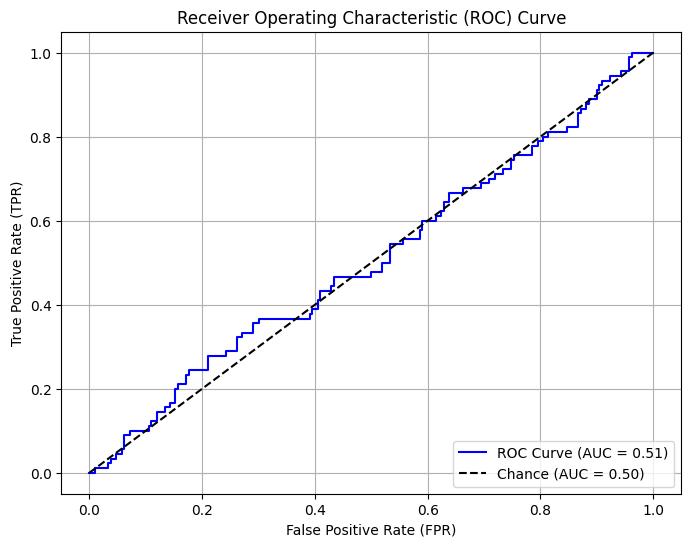

In [14]:
# --- 1. Calculate ROC Curve values ---
# Get the predicted probabilities for the positive class (Failure)
# This was already calculated in the previous script
y_pred_proba = xgb_aug.predict_proba(X_test)[:, 1]

print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

# Calculate the False Positive Rate, True Positive Rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the Curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)


# --- 2. Plot the ROC Curve ---
plt.figure(figsize=(8, 6))
# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
# Plot the "chance" line (a model with no skill)
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')

# --- 3. Add Labels and Title for Clarity ---
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

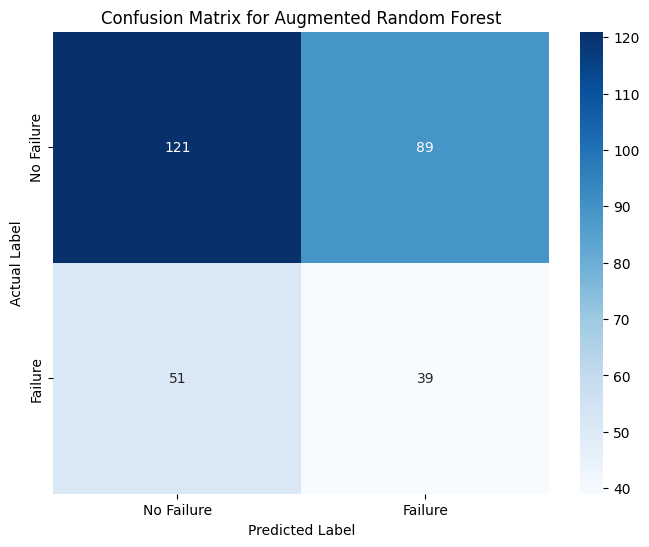

In [15]:

# 1. Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb_aug)

# 2. Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,      # Show the numbers in each cell
    fmt='d',         # Format numbers as integers
    cmap='Blues',    # Use a blue color theme
    xticklabels=['No Failure', 'Failure'], 
    yticklabels=['No Failure', 'Failure']
)

# 3. Add labels and title for clarity
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for Augmented Random Forest')
plt.show()


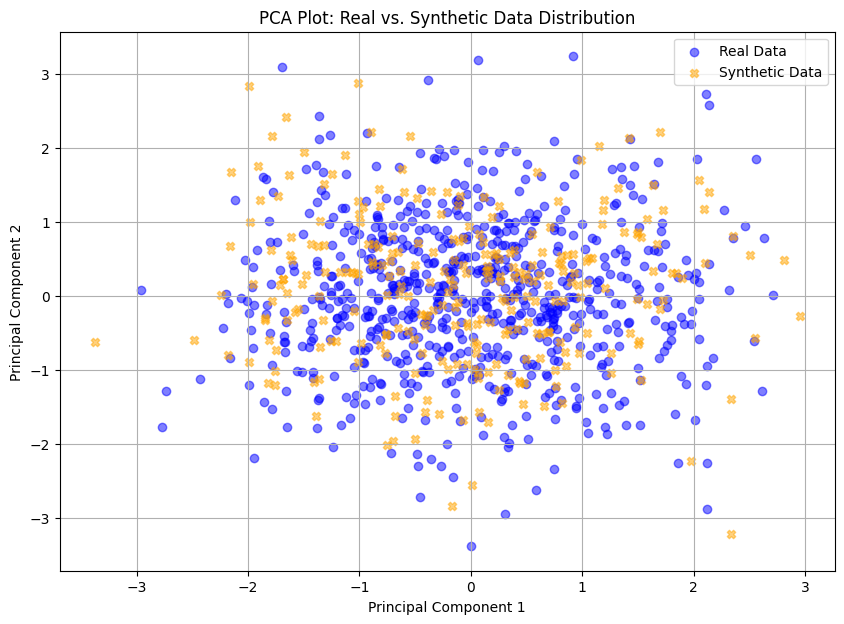

In [16]:
from sklearn.decomposition import PCA

# --- Prepare Synthetic Data for PCA ---
# The same transformations that were applied to the training data must be applied here.

# 1. Copy the synthetic data to a new dataframe for preprocessing
synthetic_data_pca = synthetic_data.drop('Failure_Risk', axis=1).copy()

# 2. Apply the SAME LabelEncoder and StandardScaler that were fitted on the training data
synthetic_data_pca['Machine_Type'] = le.transform(synthetic_data_pca['Machine_Type'])
synthetic_data_pca[numerical_cols] = scaler.transform(synthetic_data_pca[numerical_cols])


# --- Apply PCA ---
# We will reduce the data to 2 dimensions for easy visualization.
pca = PCA(n_components=2)

# Fit the PCA model on the REAL training data and transform it
X_train_pca = pca.fit_transform(X_train)

# Transform the SYNTHETIC data using the SAME fitted PCA model
synthetic_data_pca_transformed = pca.transform(synthetic_data_pca)


# --- Create the Visualization ---
plt.figure(figsize=(10, 7))

# Create a scatter plot for the REAL data
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5, label='Real Data', c='blue')

# Create a scatter plot for the SYNTHETIC data on the same plot
plt.scatter(synthetic_data_pca_transformed[:, 0], synthetic_data_pca_transformed[:, 1], alpha=0.5, label='Synthetic Data', c='orange', marker='X')

# --- Add Labels and Title for Clarity ---
plt.title('PCA Plot: Real vs. Synthetic Data Distribution')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()